# Code to run UE solver processes:

### Introduction

This UE Solver takes an origin-destination demand input (origin, destination, number of cars taking this path) and a road network and assigns a path for each trip such that **the travel time for each trip is minimized.** The solver finds the [static user equilibrium](https://en.wikipedia.org/wiki/Route_assignment#Equilibrium_assignment) network flows.

In addition to solving this problem, the UE Solver has several methods to simulate alternative road networks. Reasons for altering the road network include increasing/decreasing road capacity, simulating road closures, floods, or any sort of disruption in the original road network. 

Processing the results will convert the assigned travel to a geojson file. In addition, processing results can calculate VMT, VHT, and delay.

### Notes
These instructions assume that a pre-step has been done to generate a networkx graph of the network.
It is also assumed that we have converted the graph to a geojson and added appropriate extra fields (like city, county, etc.) 

If this is not the case - these steps can be completed in the "Converting networkx into geojson (only has to be done once)" cell [below](#convertingtogeojson) <a href = "#convertingtogeojson"> </a>.

To run the solver, we require the following inputs:
* Networkx graph
* Demand file grouped by some partitions of an area (i.e. TAZ, city, county, district, etc)
    * Demand file should have three columns: origin, destination, and flow
* Shapefile corresponding to the above demand file

# Using the solver

### 1. Modifying the network (optional)
* [Update network capacity](#network-capacity)
<a href = "#network-capacity"> </a>
* [Cut links](#cut-links)
<a href = "cut-links"></a>

### 2. Run solver [here](#run-solver)
<a href = "#run-solver"></a>

### 3. Process results [here](#process-results)
<a href = "#process-results"></a>

<a id = "convertingtogeojson"> </a>
# Converting networkx into geojson (only has to be done once)
If geojson exists for the network of interest, than should not need to run this cell.

In [2]:
from ue_solver.conversions import networkx_to_geojson
from ue_solver.modify_network import remove_duplicate_links
from ue_solver.modify_network import label_road_network, append_city_names

#inputs:
graph_f='resources/network/sf_freeway/network_graph.txt'
geojson_f ='resources/network/sf_secondary/network.geojson' 

networkx_to_geojson(graph_f, geojson_outf=geojson_f)

# if this is the first time creating a geojson from a networkx, probably want to 
# run the following clean-up:
remove_duplicate_links(geojson_inf=geojson_f, geojson_outf=geojson_f)

#to add city (and county) info:
ca_cities_shp = 'resources/shapefiles/ca_cities_2014'
label_road_network(ca_cities_shp, geojson_f, ['CityType','County','NAME'], geojson_f, ['city', 'county', 'name'])

<a id="network-capacity"> </a>
# Modifying network: 
## 1. Update network capacity:
* Simulate different capacities in network
* Requires geoJSON format of networkx graph (can be obtained from conversion in the above cell)

In [3]:
from ue_solver.modify_network import update_capacity

attr_dict = {'county': ['Alameda']}
# attr_dict = {'city': ['Berkeley', 'Oakland']}
percent_cap = .5
geojson_inf = 'resources/network/sf_secondary/network.geojson'
geojson_outf = 'resources/network/sf_secondary/alameda_0p5/network.geojson'
graph_outf = 'resources/network/sf_secondary/alameda_0p5/network_graph.txt'

update_capacity(attr_dict, percent_cap, geojson_inf, 
                geojson_outf, graph_outf)

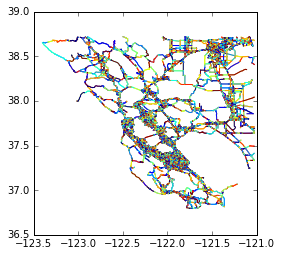

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas as gpd

gpd_network = gpd.read_file(geojson_inf)
gpd_network.plot()

<a id = "cut-links"> </a>
## 2. Cut links:
* Simulate network with links removed
* Cut links is a CSV file of links that will be removed (to simulate road closures, etc)
* **Note on formatting**:
    * CSV file should have 2 columns, OSM init and OSM terminal (from Open Street Maps)

In [4]:
from ue_solver.modify_network import cut_links

#Inputs:
geojson_inf = 'resources/network/sf_secondary/network.geojson'
links_f = 'resources/cut_links/test_cutlinks/berkeley_cut_links.csv'
geojson_outf = 'resources/network/sf_secondary/berkeley_w_cutlinks/network.geojson'
graph_outf = 'resources/network/sf_secondary/berkeley_w_cutlinks/network_graph.txt'

cut_links(geojson_inf, links_f, geojson_outf, graph_outf)

<a id = "run-solver"> </a>
# Run solver

In [2]:
from ue_solver import run_solver

taz_demand_f = 'resources/demand/TAZ_sf_demand.csv'
network_graph = 'resources/network/sf_secondary/network_graph.txt'
output_file = 'resources/results/sf_secondary_demand_1p5_gap100.txt'

run_solver.run_solver_full(network_graph, taz_demand_f, output_file, 
                           taz_shapefile='resources/shapefiles/bay_area_tazs',
                           demand_scale = 1.5, distance_factor=0, toll_factor=0, 
                           gap = 10.0)


('started at', 1494267675.206177)
Running FW algorithm
('done in', 573.7344999313354, 'sec')


<a id = "process-results"></a>
# Process results
* Now that the results have been generated from "Run solver", we can analyze VMT (Vehicle Miles Traveled), VHT (Vehicle Hours Traveled), and Delay (difference from free flow time)
* The geojson file can be uploaded into QGIS to visualize results.

## 1. Results to geojson

In [1]:
from ue_solver.process_results import results_to_geojson

#Inputs:
results_f = 'resources/results/sf_secondary/demand_1p5_gap100.txt'
geojson_inf = 'resources/network/sf_secondary/network.geojson'
geojson_outf = 'resources/results/sf_secondary/demand_1p5_gap100.geojson'

results_to_geojson(results_f, geojson_inf, geojson_outf)

/Users/madeleinesheehan/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## 2. VMT, VHT, Delay
Takes the results calculated from solver and sums miles, hours and delay for each trip to calculate vehicle miles traveled, vehicle hours traveled and delay respectively.

Vehical miles traveled and vehicle hours traveled are calculated by multiplying flow across a link by the length and time traveled respectively. 
Delay is calculated by taking the difference between result travel time and free flow travel time.


In [1]:
from ue_solver.process_results import geoj_vmt_vht_delay
from ue_solver.process_results import get_total_demand
import time


start = time.time()
print('started at', start)

results_geoj = 'resources/results/sf_secondary/demand_1p5_gap100.geojson'

demand_f = 'resources/demand/TAZ_sf_demand.csv'
totalODflow = get_total_demand(demand_f, demand_scale=1.5)
min_speed = 0
cities_aggregate_output_file = 'resources/results/sf_secondary/vmt_vht_delay_cities.csv'
output_summary = 'resources/results/sf_secondary/vmt_vht_delay_summary.csv'
city_plots_save_path = 'resources/results/sf_secondary/city_vmt_vht_delay.pdf'

geoj_vmt_vht_delay(results_geoj, cities_aggregate_output_file, output_summary, totalODflow, min_speed, 
                   city_plots_save_path)

print('done in', time.time()-start, 'sec')

/Users/madeleinesheehan/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


('started at', 1494277294.480506)
The file 'resources/results/sf_secondary/vmt_vht_delay_summary.csv' already exists. Would you like to write over it? (y/n)y
totalvmt: 14742299.6647
totalvht: 657962.116552
totaldelay: 325307.168502
vmt per traveler: 9.53592165854
vht per traveler: 0.425596775295
delay per traveler: 0.21042196566
The file 'resources/results/sf_secondary/city_vmt_vht_delay.pdf' already exists. Would you like to write over it? (y/n)y
('done in', 441.71195006370544, 'sec')
